# Why Hawkes processes?

Hawkes process is one of the most popular processes used nowadays to model and explain the **market's microstructure**. This is because these processes are self-exciting, meaning that past events directly influence the time arrival of future events. This is made possible by introducing a conditional intensity which introduces a **clustering effect between events**. This can for instance model the typical U graph we obtain when we plot the market activity over a day where we observe low trading activity during lunch time. 

**The dataset is the order book of Amazon**. We retrieve the **timestamps** of events and fit a Hawkes model. The precision of timestamps wasn't always enough to differentiate two events so a tiny random uniform time was added to each timestamp to split them. First, we focus on data of **1 hour of trading**. 

In [ ]:
%pip install hawkeslib

Note: hawkeslib only supports Python 2.7 and 3.6 so this notebook is very likely to only work on Google Colab

In [ ]:
%pip install hawkes

In [44]:
%matplotlib inline
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from hawkeslib.model.mv_exp import MultivariateExpHawkesProcess as MVHP
import Hawkes as hk
import seaborn as sns

In [325]:
order_book = pd.read_csv('AMZN_2012-06-21_34200000_57600000_message_10.csv', header=None)
order_book.columns = columns = ['Time', 'Type', 'Order ID', 'Size', 'Price', 'Direction']
df = order_book.drop(['Order ID', 'Size', 'Price', 'Type'], axis=1)
df = df[['Direction', 'Time']]
dico = {-1:0, 1:1}
df['Direction'] = df['Direction'].map(dico)
df['Time'] = df['Time'] - df['Time'].min()
df['Time'] = df['Time'].apply(lambda x: x+np.random.uniform(1e-7, 2e-7)) #some timestamps are the identical
df = df.sort_values(by=['Time'])
df = df[df['Time']<=3600] #only an hour

In [326]:
df.head()

,Direction,Time
0,0,1.616703e-07
18,0,1.721482e-01
22,0,1.721482e-01
24,0,1.721482e-01
3,1,1.721482e-01


In the next section we will focus on three different types of Hawkes processes to see which one fits best the data. There will be two univariate Hawkes processes, the first one with a **power-law** kernel and the second one with a sum of three **exponentials kernel**. Power-law kernels are usually preferred because they decrease slower which reflects best the **"memory" of the market**. However, computations are very slow. This is why we also introduce a sum of three exponentials kernels to have several speed decays. We will also fit a **two-dimensional** Hawkes process with exponential kernels where each dimension corresponds to the **direction** of the order (sell or buy), the idea being that these orders can both be modeled by a Hawkes process but, in addition to that, they **mutually excite each other**.

# Two-dimensional Hawkes process with exponential kernels

$\lambda^*_k(t) = \mu_k + \sum_{t_i < t} A(c_i, k) \theta \exp(-\theta (t - t_i))$

In [327]:
t = df['Time'].values
c = df['Direction'].values

mv = MVHP()
mv.fit(t, c)

140959.50727682456

<ipython-input-234-59fd5d3213ff>:2: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  ax[0].stem(mv._mu)


Text(0.5, 1.0, '$A$')

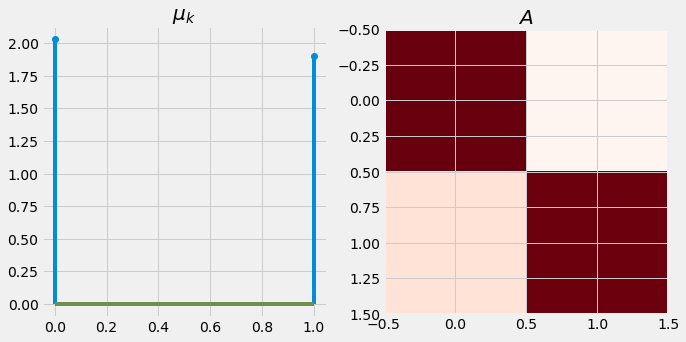

In [234]:
f, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].stem(mv._mu)
ax[0].set_title("$\mu_k$")
ax[1].imshow(mv._A, cmap="Reds")
ax[1].set_title("$A$")

The heatmap on the right can be interpreted as a **correlation matrix** except that it isn't necessarily symmetric and raging from 0 to 1. Cell(0,0) can be seen as the **influence coefficient** of a sell order on a sell order. Same for buy in Cell(1,1). Cell(0,1) is the influence coefficient of a buy order on a sell order. Note that Cell(0,1) != Cell(1,0) which models the fact that **markets aren't symmetric**: for a same percentage in price change, people act differently if the stock went down (panic) than up. Here Cell(1,0)>Cell(0,1) which seems consistent with the previous observation.

## Parameters of fit

In [235]:
mv._mu

array([2.0307105 , 1.90080163])

In [236]:
mv._A

array([[0.51408485, 0.13648799],
       [0.17669641, 0.50825907]])

In [237]:
mv._theta

1314.9113895060525

# Univariate Hawkes process with a sum of three exponentials

- multiple exponential function : $f(\tau)=\sum_{i=1}^{num\_exp}\alpha_i \beta_i \exp(-\beta_i \tau)$

In [238]:
def mle_hawkes_exps(timestamps, T):
    model = hk.estimator()
    model.set_kernel('exp',num_exp=3)
    model.set_baseline('const')
    model.fit(timestamps,[0,T])
    para = model.parameter
    return para['mu'], para['alpha'], para['beta']

In [239]:
mu, alpha, beta = mle_hawkes_exps(t, np.max(t))

## Parameters of fit

In [240]:
mu

2.314573904024835

In [241]:
alpha

array([0.40680123, 0.20021978, 0.19686644])

In [242]:
beta

array([ 1178.82275392,    34.7667252 , 17939.89727871])

# Univariate Hawkes process with a power law kernel

- power-low function : $f(\tau)=k/(\tau+c)^p$

In [243]:
def mle_hawkes(timestamps, T):
      model = hk.estimator()
      model.set_kernel('pow')
      model.set_baseline('const')
      model.fit(timestamps,[0,T])
      para = model.parameter
      return para['mu'], para['k'], para['p'], para['c']

In [244]:
mu_pl, k, p, c = mle_hawkes(t, np.max(t))

## Parameters of fit

In [245]:
mu_pl

2.104349090395264

In [246]:
k

0.0048809916005862555

In [247]:
p

1.5744582953839636

In [248]:
c

0.0003496080313168356

# Comparing inter-arrival times distribution

Looking at the distribution of timestamps doesn't really make sense to see how good the model fitted the data. Instead, it is more relevant to study the **inter-arrival time distribution** (i.e. time elapsed between two consecutive events).

In [249]:
# multivariate

hp = MVHP()
hp.set_params(mv._mu, mv._A, mv._theta)
hawkes_multi, _ = hp.sample(np.max(t))

In [250]:
# powerlaw

def generate_hawkes(mu_pl, k, p, c, T):
      model = hk.simulator()
      model.set_kernel('pow')
      model.set_baseline('const')
      para = {'mu': mu_pl,'k': k, 'p': p, 'c': c}
      model.set_parameter(para)
      itv = [0, T]
      process = model.simulate(itv)
      return process

In [251]:
hawkes_pl = generate_hawkes(mu_pl, k,p,c,np.max(t))

In [252]:
#exponentials

def generate_hawkes_exps(mu, alpha, beta, T):
      model = hk.simulator()
      model.set_kernel('exp', num_exp=3)
      model.set_baseline('const')
      para = {'mu': mu, 'alpha': alpha, 'beta': beta}
      model.set_parameter(para)
      itv = [0, T]
      process = model.simulate(itv)
      return process

In [253]:
hawkes_exps = generate_hawkes_exps(mu, alpha, beta, np.max(t))

## Histogram

## On the first hour of trading

In [257]:
# plot all inter-arrival times smaller than threshold
threshold = 1e-3

#true data
df['diff'] = df['Time'].diff()
df_copy = df.copy()
df_copy = df_copy.dropna()
df_copy = df_copy[df_copy['diff']<threshold]

#hawkes_exps dim 1
hawkes_exps_diff = np.diff(hawkes_exps)
hist_hawkes_exps = hawkes_exps_diff[np.where(hawkes_exps_diff<threshold)]

#multivariate hawkes
hawkes_multi_diff = np.diff(hawkes_multi)
hist_hawkes_multi = hawkes_multi_diff[np.where(hawkes_multi_diff<threshold)]

#powerlaw
hawkes_pl_diff = np.diff(hawkes_pl)
hist_hawkes_pl = hawkes_pl_diff[np.where(hawkes_pl_diff<threshold)]


Text(0.5, 1.0, 'Inter-arrival time distributions: exponentials vs real data')

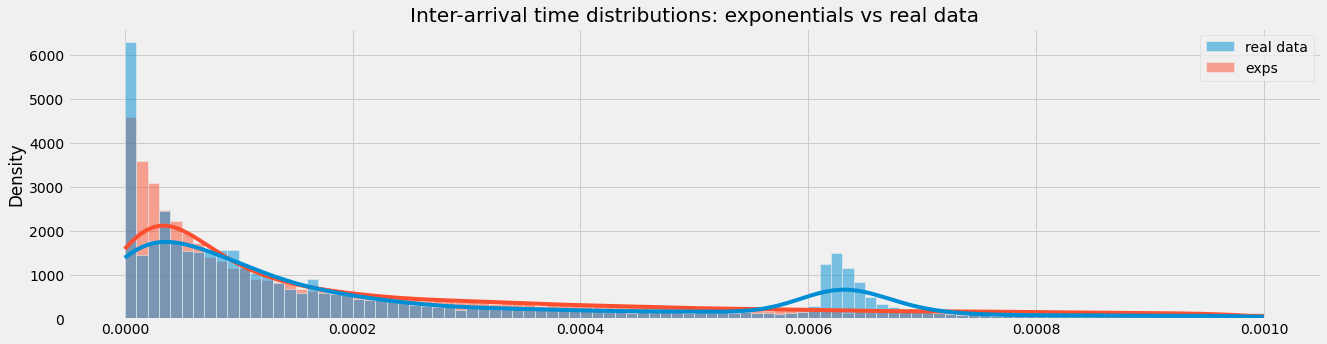

In [258]:
#exponentials vs real data
fig, ax1 = plt.subplots(figsize=(20,5))
sns.histplot((df_copy['diff'], hist_hawkes_exps), bins=100, stat='density', kde=True)

legend = ax1.get_legend()
handles = legend.legendHandles
legend.remove()
ax1.legend(handles, ['real data', 'exps'])
plt.title("Inter-arrival time distributions: exponentials vs real data")

Text(0.5, 1.0, 'Inter-arrival time distributions: multivariate vs real data')

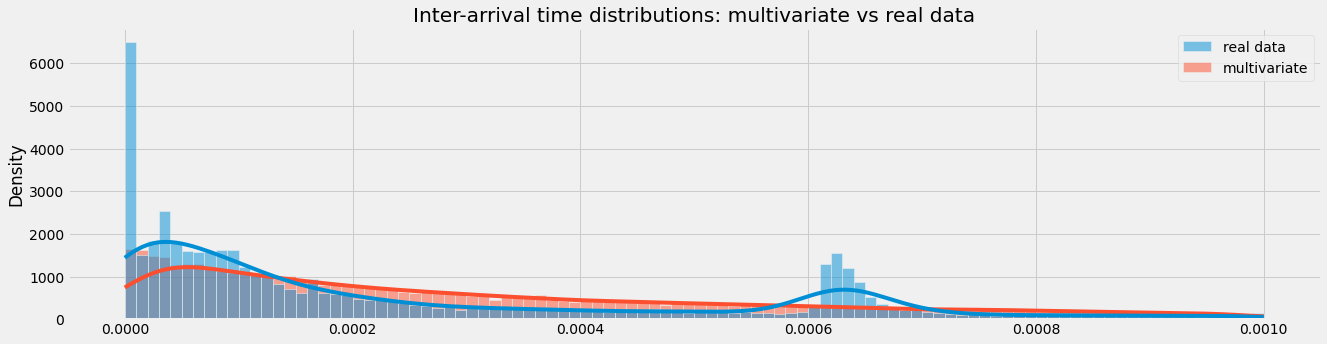

In [259]:
fig, ax1 = plt.subplots(figsize=(20,5))
sns.histplot((df_copy['diff'], hist_hawkes_multi), bins=100, stat='density', kde=True)

legend = ax1.get_legend()
handles = legend.legendHandles
legend.remove()
ax1.legend(handles, ['real data', 'multivariate'])
plt.title("Inter-arrival time distributions: multivariate vs real data")

Text(0.5, 1.0, 'Inter-arrival time distributions: powerlaw vs real data')

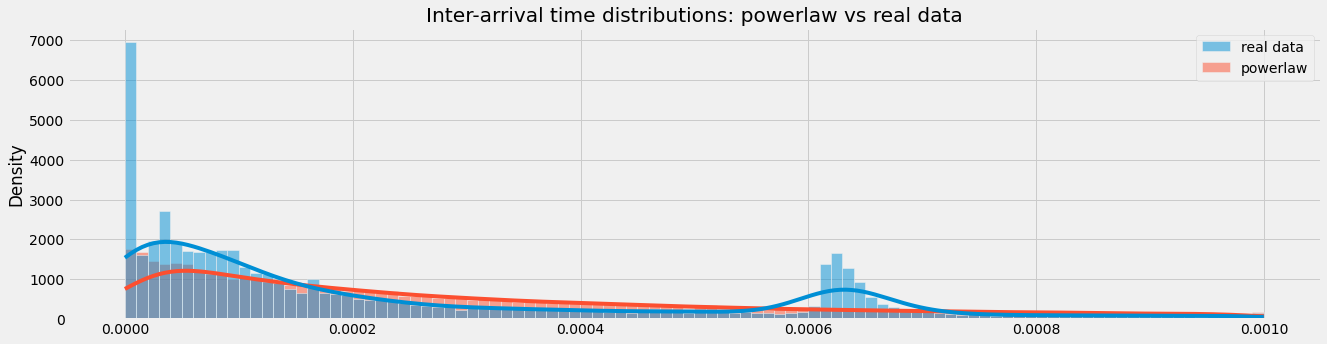

In [260]:
fig, ax1 = plt.subplots(figsize=(20,5))
sns.histplot((df_copy['diff'], hist_hawkes_pl), bins=100, stat='density', kde=True)

legend = ax1.get_legend()
handles = legend.legendHandles
legend.remove()
ax1.legend(handles, ['real data', 'powerlaw'])
plt.title("Inter-arrival time distributions: powerlaw vs real data")

The univariate Hawkes process with a **sum of three exponentials** kernel is the best fit. Maybe fitting on **1 hour** of trading is **too much**. Lets see how it performs on the first **30 minutes**. Futhermore, we note that none of the three models is capable to model the spike on the right side of the graph.

## On the first 30 minutes

In [261]:
df_30 = df[df['Time']<30*60]
t_30 = df_30['Time'].values
c_30 = df_30['Direction'].values

In [262]:
#two dimensional
mv_30 = MVHP()
mv_30.fit(t_30, c_30)

#exps
mu_30, alpha_30, beta_30 = mle_hawkes_exps(t_30, np.max(t_30))

#powerlaw
mu_pl_30, k_30, p_30, c_30 = mle_hawkes(t_30, np.max(t_30))


In [263]:
# multivariate

hp_30 = MVHP()
hp_30.set_params(mv_30._mu, mv_30._A, mv_30._theta)
hawkes_multi_30, _ = hp_30.sample(np.max(t_30))

#powerlow
hawkes_pl_30 = generate_hawkes(mu_pl_30, k_30,p_30,c_30,np.max(t_30))

#exps
hawkes_exps_30 = generate_hawkes_exps(mu_30, alpha_30, beta_30, np.max(t_30))


In [ ]:
# plot all inter-arrival times smaller than threshold
threshold = 1e-3

#true data
df_30['diff'] = df_30['Time'].diff()
df_copy_30 = df_30.copy()
df_copy_30 = df_copy_30.dropna()
df_copy_30 = df_copy_30[df_copy_30['diff']<threshold]

#hawkes_exps dim 1
hawkes_exps_diff_30 = np.diff(hawkes_exps_30)
hist_hawkes_exps_30 = hawkes_exps_diff_30[np.where(hawkes_exps_diff_30<threshold)]

#multivariate hawkes
hawkes_multi_diff_30 = np.diff(hawkes_multi_30)
hist_hawkes_multi_30 = hawkes_multi_diff_30[np.where(hawkes_multi_diff_30<threshold)]

#powerlaw
hawkes_pl_diff_30 = np.diff(hawkes_pl_30)
hist_hawkes_pl_30 = hawkes_pl_diff_30[np.where(hawkes_pl_diff_30<threshold)]

Text(0.5, 1.0, 'Inter-arrival time distributions: exponentials vs real data')

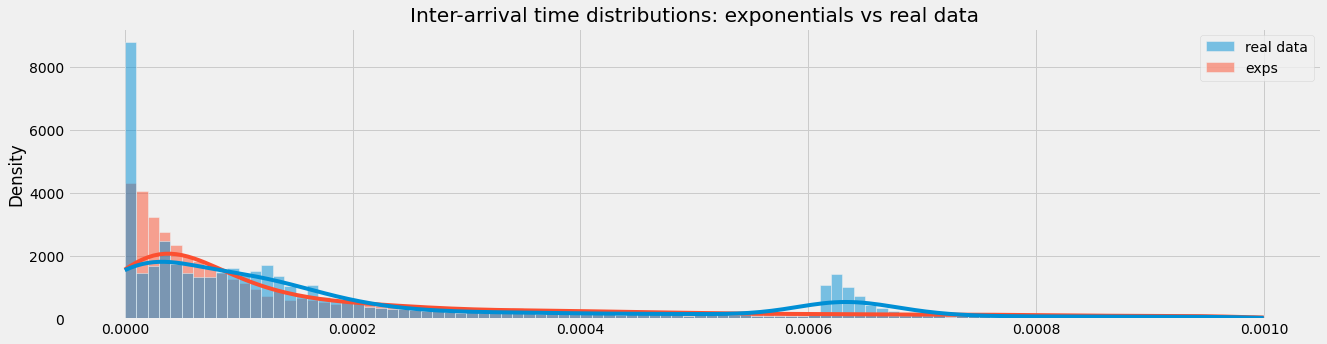

In [265]:
#exponentials vs real data
fig, ax1 = plt.subplots(figsize=(20,5))
sns.histplot((df_copy_30['diff'], hist_hawkes_exps_30), bins=100, stat='density', kde=True)

legend = ax1.get_legend()
handles = legend.legendHandles
legend.remove()
ax1.legend(handles, ['real data', 'exps'])
plt.title("Inter-arrival time distributions: exponentials vs real data")

Text(0.5, 1.0, 'Inter-arrival time distributions: multivariate vs real data')

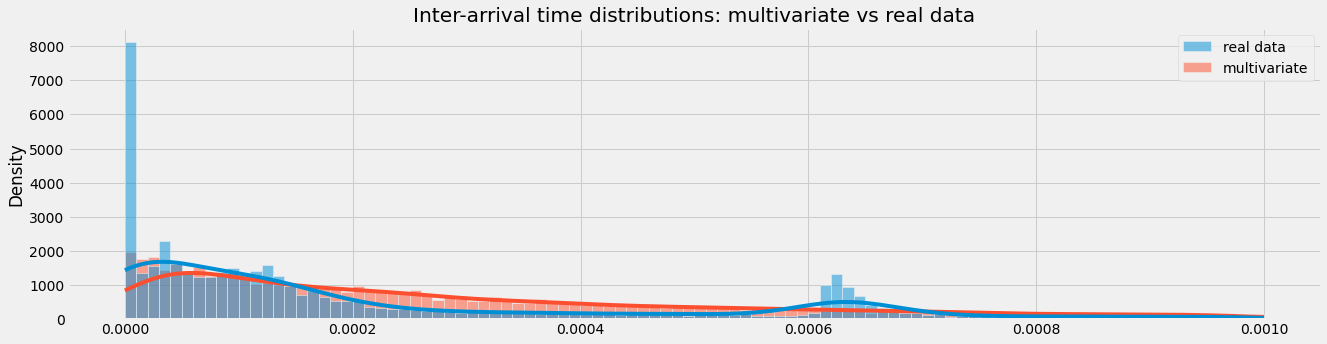

In [266]:
fig, ax1 = plt.subplots(figsize=(20,5))
sns.histplot((df_copy_30['diff'], hist_hawkes_multi_30), bins=100, stat='density', kde=True)

legend = ax1.get_legend()
handles = legend.legendHandles
legend.remove()
ax1.legend(handles, ['real data', 'multivariate'])
plt.title("Inter-arrival time distributions: multivariate vs real data")

Text(0.5, 1.0, 'Inter-arrival time distributions: powerlaw vs real data')

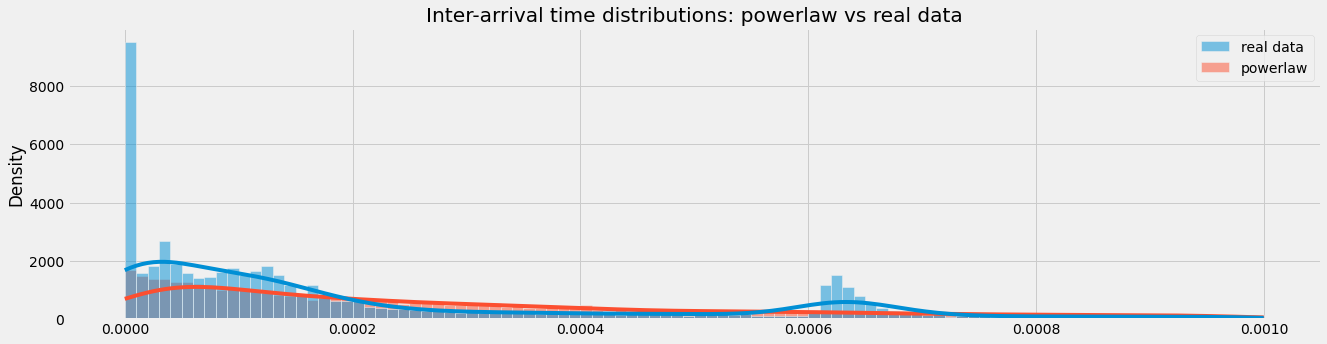

In [267]:
fig, ax1 = plt.subplots(figsize=(20,5))
sns.histplot((df_copy_30['diff'], hist_hawkes_pl_30), bins=100, stat='density', kde=True)

legend = ax1.get_legend()
handles = legend.legendHandles
legend.remove()
ax1.legend(handles, ['real data', 'powerlaw'])
plt.title("Inter-arrival time distributions: powerlaw vs real data")

Once again, the univariate process with a **sum of exponentials** has the best fit. Especially, it is the only one capable of modelling a **very strong activity on very little time periods**. This is probably due to the fact that we have **three speed degrees** because of the three exponentials. Lets keep investigating this multiple speed degree idea by **adding more exponentials**. Futhermore, we note that none of the three models is capable to model the spike on the right side of the graph.

In [268]:
#exponentials

def generate_hawkes_exps_modif(mu, alpha, beta, T, nb_exps):
      model = hk.simulator()
      model.set_kernel('exp', num_exp=nb_exps)
      model.set_baseline('const')
      para = {'mu': mu, 'alpha': alpha, 'beta': beta}
      model.set_parameter(para)
      itv = [0, T]
      process = model.simulate(itv)
      return process

In [269]:
def mle_hawkes_exps_modif(timestamps, T, nb_exps):
    model = hk.estimator()
    model.set_kernel('exp',num_exp=nb_exps)
    model.set_baseline('const')
    model.fit(timestamps,[0,T])
    para = model.parameter
    return para['mu'], para['alpha'], para['beta']

## On 30 minutes and with 4 exponentials

In [270]:
mu_30_4, alpha_30_4, beta_30_4 = mle_hawkes_exps_modif(t_30, np.max(t_30), nb_exps=4)

In [271]:
#exps
hawkes_exps_30_4 = generate_hawkes_exps_modif(mu_30_4, alpha_30_4, beta_30_4, np.max(t_30), nb_exps=4)

In [272]:
#hawkes_exps dim 1
hawkes_exps_diff_30_4 = np.diff(hawkes_exps_30_4)
hist_hawkes_exps_30_4 = hawkes_exps_diff_30_4[np.where(hawkes_exps_diff_30_4<threshold)]

Text(0.5, 1.0, 'Inter-arrival time distributions: exponentials vs real data')

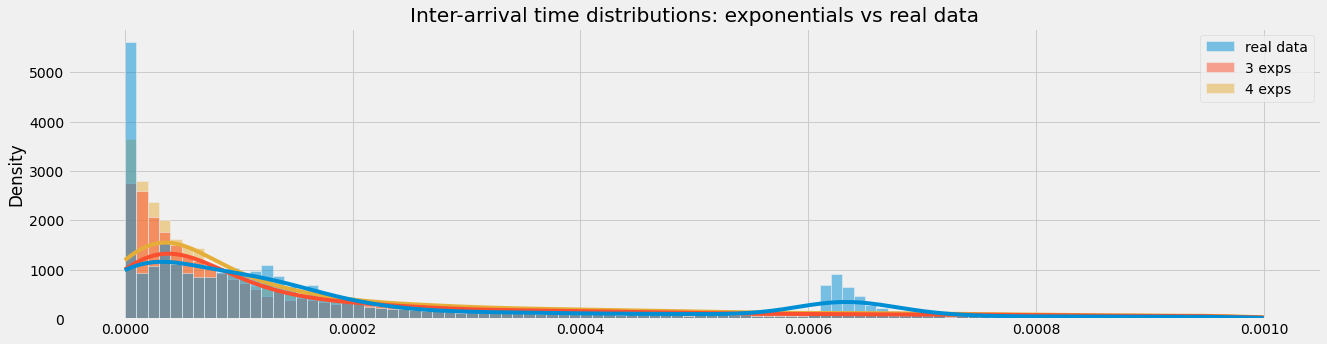

In [273]:
#exponentials vs real data
fig, ax1 = plt.subplots(figsize=(20,5))
sns.histplot((df_copy_30['diff'], hist_hawkes_exps_30, hist_hawkes_exps_30_4), bins=100, stat='density', kde=True)

legend = ax1.get_legend()
handles = legend.legendHandles
legend.remove()
ax1.legend(handles, ['real data', '3 exps', '4 exps'])
plt.title("Inter-arrival time distributions: exponentials vs real data")

We note that adding an exponential didn't increase the precision of the fit. The model is slightly capable to better capture strong activity in tiny time periods but **can't fit the huge drop that comes just after the first pike**. 

#5th order Hawkes process for 5 different type orders

In this section we will fit the distribution of orders according to their type identified by an integer ranging from 1 to 5. 

1) Submission of a new limit order

2) Cancellation (Partial deletion of a limit order)

3) Deletion (Total deletion of a limit order)

4) Execution of a visible limit order	

5) Execution of a hidden limit order


The objective is to see how they are intercorrelated.

In [302]:
message = pd.read_csv('AMZN_2012-06-21_34200000_57600000_message_10.csv', header=None)
columns = ['Time', 'Type', 'Order ID', 'Size', 'Price', 'Direction']
message.columns = columns
dico = {1:0, 2:1, 3:2, 4:3, 5:4, 7:5}
message = message.drop(['Time', 'Order ID', 'Size', 'Price', 'Direction'], axis=1)
message['Type'] = message['Type'].map(dico)
message.reset_index(drop=True, inplace=True)
messages = message.values


In [322]:
messages.shape

(269748, 1)

In [338]:
order_book = pd.read_csv('AMZN_2012-06-21_34200000_57600000_message_10.csv', header=None)
order_book.columns = columns = ['Time', 'Type', 'Order ID', 'Size', 'Price', 'Direction']
df = order_book.drop(['Order ID', 'Size', 'Price', 'Type', 'Direction'], axis=1)
df['Time'] = df['Time'] - df['Time'].min()
df['Time'] = df['Time'].apply(lambda x: x+np.random.uniform(1e-7, 2e-7)) #some timestamps are identical
df = df.sort_values(by=['Time'])
ts = df.values

In [347]:
np.unique(messages)

array([0, 1, 2, 3, 4])

In [344]:
t_arr = np.zeros(len(ts))
t_arr.shape
for i in range(len(ts)):
  t_arr[i] = ts[i]
  

In [343]:
t_msg = np.zeros(len(ts))
t_msg.shape
for i in range(len(ts)):
  t_msg[i] = messages[i]

<ipython-input-345-89af21fb51ef>:4: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  ax[0].stem(mv_end._mu)


Text(0.5, 1.0, '$A$')

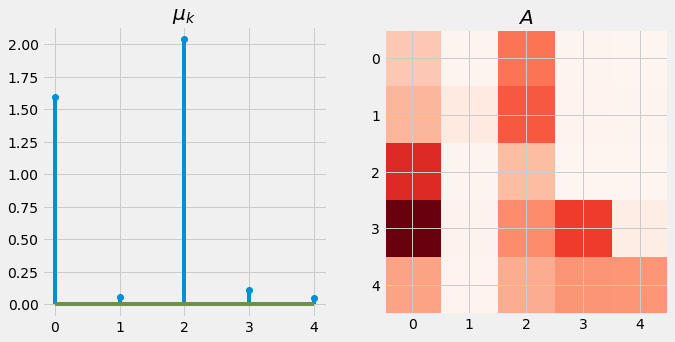

In [345]:
mv_end = MVHP()
mv_end.fit(t_arr, t_msg)
f, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].stem(mv_end._mu)
ax[0].set_title("$\mu_k$")
ax[1].imshow(mv_end._A, cmap="Reds")
ax[1].set_title("$A$")